In [1]:
import pandas
import seaborn
import numpy as np
from sklearn import preprocessing
import time
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import spatial
import scipy
import warnings
warnings.filterwarnings('ignore')
pandas.options.display.max_rows = 72

## Building the dataframe and pre-processing the data

In [2]:
chunk = pandas.read_csv('trips.csv', chunksize=1000000)
df = pandas.concat(chunk)
df.head(3)

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,...,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,009bff6108bdad18224f166699744a5231958c0d,11/1/2018 0:00,11/1/2018 0:15,558,2.6,1.703183e+10,1.703108e+10,7.0,8.0,7.5,...,2.5,10.0,False,1,41.914747,-87.654007,POINT (-87.6540070286 41.9147473049),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365)
1,00a86e3b5eb12b9a0f08d7021b72d144e8ba9732,11/1/2018 0:00,11/1/2018 0:15,299,1.8,NaN,NaN,75.0,75.0,5.0,...,2.5,7.5,False,1,41.689730,-87.669054,POINT (-87.6690544032 41.6897299145),41.689730,-87.669054,POINT (-87.6690544032 41.6897299145)
2,00a9c99fb790a7320fbe9208933fe75f20d68122,11/1/2018 0:00,11/1/2018 0:15,472,4.0,1.703108e+10,1.703106e+10,8.0,6.0,7.5,...,2.5,10.0,False,1,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.942585,-87.656644,POINT (-87.6566440918 41.9425851797)


### Keeping only the valuable columns

In [3]:
trips = df[['Trip ID','Trip Start Timestamp','Trip End Timestamp', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Trip Seconds']]

In [4]:
trips.shape

(1005664, 8)

### Cleaning up the data

In [5]:
trips.dropna(inplace=True)
trips.reset_index(drop=True,inplace=True)
trips.columns = trips.columns.str.replace(' ', '_').str.lower()

### Extracting time/weekdays from the timestamps, and giving them their own columns

In [6]:
trips['trip_start_timestamp'] = pandas.to_datetime(trips['trip_start_timestamp'],format = '%m/%d/%Y %H:%M')
trips['trip_end_timestamp'] = pandas.to_datetime(trips['trip_end_timestamp'],format = '%m/%d/%Y %H:%M')
trips['weekday'] = trips['trip_start_timestamp'].dt.day_name()
trips['start_time'] = trips['trip_start_timestamp'].dt.time
trips['end_time'] = trips['trip_end_timestamp'].dt.time

In [7]:
trips['trip_seconds'].replace(',',"", regex=True, inplace=True)
trip_seconds = pandas.to_numeric(trips['trip_seconds'], errors='coerce')
trips['trip_seconds'] = trip_seconds

### Using K-Means to generate neighborhood clusters/centroids and assigning the neighborhood #s to each trip's pickup location

In [8]:
clus = trips[['pickup_centroid_latitude', 'pickup_centroid_longitude']]
kmeans = KMeans(n_clusters = 72, max_iter = 300, random_state = 12345)
kmeans.fit(clus)
centroids = kmeans.cluster_centers_
neighborhoods = kmeans.labels_
trips['pickup_neighborhood'] = neighborhoods

#### Using KDTree to place each dropoff location into one of the previously generated neighborhoods

In [9]:
def do_kdtree(centroids, points):
    mytree = scipy.spatial.cKDTree(centroids)
    dist, indexes = mytree.query(points)
    return indexes
dropoff_centroid_location = list(zip(trips['dropoff_centroid_latitude'], trips['dropoff_centroid_longitude']))
dropoff_neighborhoods = do_kdtree(centroids, dropoff_centroid_location)
trips['dropoff_neighborhood'] = dropoff_neighborhoods.tolist()

### Visualizing the neighborhood centroids on a grid

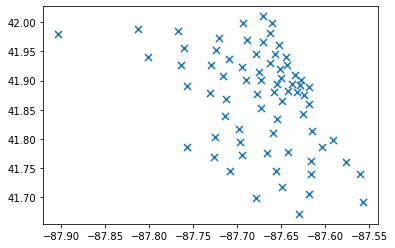

In [10]:
plt.scatter(centroids[:,1], centroids[:,0], marker='x', s=50)
plt.show()

### Visualizing the Kmeans clusters on a graphic distibution

<Figure size 1440x1152 with 0 Axes>

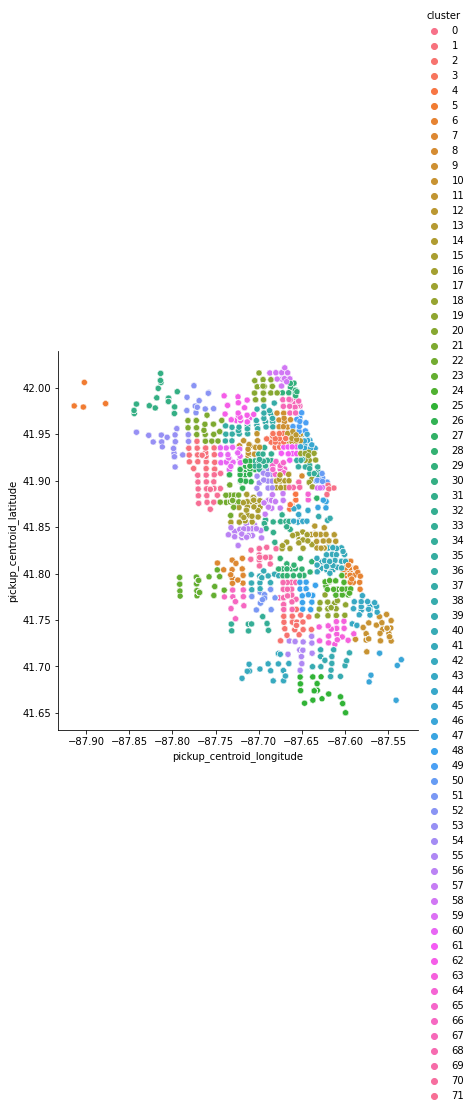

In [11]:
clus['cluster'] = kmeans.fit_predict(clus)
clus['cluster'] = clus['cluster'].astype("category")
plt.figure(figsize=(20,16))
chicago_clusters = seaborn.relplot(data=clus, x="pickup_centroid_longitude", y="pickup_centroid_latitude", hue="cluster", height=6)


### Visualizing neighborhood centroids on a map of Chicago

In [12]:
import folium
from folium import IFrame, FeatureGroup, LayerControl, Map, Marker, plugins
Chicago_coordinates = (41.895140898, -87.624255632)
chicago_map = folium.Map(location=Chicago_coordinates,
                        zoom_start=11)
#convert the array into list
centroid = centroids.tolist()
# Plotting the centroids on google map using Folium library.
for point in range(0, len(centroid)):
    folium.Marker(centroid[point], popup = centroid[point]).add_to(chicago_map)
chicago_map

In [13]:
chicago_map.save("chicago_map.html")

### Cluster centroids ranked by activity and plotted over map of Chicago

In [14]:
Chicago_coordinates = (41.895140898, -87.624255632)
chicago_map_ranked = folium.Map(location=Chicago_coordinates,
                        zoom_start=11)
#convert the array into list
centroid = centroids.tolist()
# Plotting the centroids on google map using Folium library.
for point in range(0, len(centroid)):
    folium.CircleMarker(centroid[point],radius=neighborhoods[point]/2, color='green',fill_color='green',fill_opacity=0.6, popup = centroid[point]).add_to(chicago_map_ranked)
chicago_map_ranked

In [15]:
chicago_map_ranked.save("chicago_map_ranked.html")

### Sorting the trip data by weekday, time, and pickup neighborhood to find the busiest areas

In [16]:
weekdays = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
for wd in weekdays:
    globals()[f'trips_{wd}'] = trips.groupby([trips[trips['weekday']==wd].start_time, trips[trips['weekday']==wd].pickup_neighborhood]).size()

In [17]:
Thursday = trips_Thursday.to_frame('count')
Friday = trips_Friday.to_frame('count')
Saturday = trips_Saturday.to_frame('count')
trips_Thursday_srtd = Thursday.sort_values(by=['start_time', 'count'], ascending=False)
trips_Friday_srtd = Friday.sort_values(by=['start_time', 'count'], ascending=False)
trips_Saturday_srtd = Saturday.sort_values(by=['start_time', 'count'], ascending=False)

In [18]:
trips_Friday_srtd.head(7200)

count
start_time pickup_neighborhood       
23:45:00   59.0                   307
           4.0                    285
           14.0                   212
           12.0                   198
           50.0                   188
...                               ...
00:00:00   51.0                     3
           52.0                     3
           55.0                     3
           46.0                     2
           66.0                     1

[6815 rows x 1 columns]

### Normalizing the data (Just Friday for now)

In [19]:
friday_nrml = trips_Friday_srtd.groupby('start_time').transform(lambda x: (x - x.min()) / (x.max() - x.min()))
friday_nrml

count
start_time pickup_neighborhood          
23:45:00   59.0                 1.000000
           4.0                  0.927869
           14.0                 0.688525
           12.0                 0.642623
           50.0                 0.609836
...                                  ...
00:00:00   51.0                 0.014286
           52.0                 0.014286
           55.0                 0.014286
           46.0                 0.007143
           66.0                 0.000000

[6815 rows x 1 columns]

## Recommendation Algorithm

In [20]:
def first_fare_finder(trips):
    # for testing purposes, we find a random fare that starts during rush hour, downtown, on Friday
    first_fare = trips[trips['start_time']==(datetime.time(17,0))]
    first_fare = first_fare[first_fare['pickup_neighborhood'] == 12]
    first_fare = first_fare[first_fare['weekday'] == 'Friday']
    first_fare = first_fare.sample(n=1)
    return first_fare

In [21]:
def fare_rec(candidates, current):
    # take candidate fares and assign them scores based on their dropoff location and the time-length of the trip
    candidates['trip_length_score'] = candidates['trip_seconds'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    for i, row in candidates.iterrows():
        candidates.at[i, 'drop_loc_score'] = (friday_nrml.loc[row['end_time'], row['dropoff_neighborhood']][0] * 2)
    for i, row in candidates.iterrows():
        candidates.at[i, 'total_score'] = (row['drop_loc_score'] + row['trip_length_score'])
    next_fare = candidates.iloc[candidates['total_score'].idxmax()]
    return next_fare, candidates

In [22]:
def candidate_shuffler(trips, current):
    # generate new candidate fares
    candidates = trips[trips['start_time'] == current.iloc[0]['end_time']]
    candidates = candidates[candidates['pickup_neighborhood'] == current.iloc[0]['dropoff_neighborhood']]
    candidates = candidates[candidates['weekday'] == current.iloc[0]['weekday']]
    candidates = candidates.sample(n=20)
    candidates.reset_index(inplace=True)
    return candidates

## Testing the algorithm

In [23]:
first = first_fare_finder(trips)
first

,trip_id,trip_start_timestamp,trip_end_timestamp,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_seconds,weekday,start_time,end_time,pickup_neighborhood,dropoff_neighborhood
404113,111aee04a97b68f19e1dbde8cee27d921472b7fb,2018-11-02 17:00:00,2018-11-02 17:30:00,41.949061,-87.661643,41.9427,-87.731002,1764,Friday,17:00:00,17:30:00,12,36


In [24]:
candidates = candidate_shuffler(trips,first)
candidates

,index,trip_id,trip_start_timestamp,trip_end_timestamp,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_seconds,weekday,start_time,end_time,pickup_neighborhood,dropoff_neighborhood
0,418182,f1e370f78e212ec076ca827231164d16a1113a0a,2018-11-02 17:30:00,2018-11-02 18:00:00,41.950078,-87.722611,41.972581,-87.694001,992,Friday,17:30:00,18:00:00,36,37
1,415449,c43c6bfa8a2179e75f3ff706fd4ce2c567307f2f,2018-11-02 17:30:00,2018-11-02 18:00:00,41.958798,-87.738394,41.935114,-87.751649,1258,Friday,17:30:00,18:00:00,36,1
2,415543,ccf099314013ac2b93154d96bd2ce5ccbb1221a2,2018-11-02 17:30:00,2018-11-02 17:30:00,41.958798,-87.738394,41.964636,-87.742788,369,Friday,17:30:00,17:30:00,36,21
3,414630,7a0a8b30122620644d93f40175c6207e01a5c38d,2018-11-02 17:30:00,2018-11-02 18:00:00,41.950212,-87.712814,41.885281,-87.657233,1653,Friday,17:30:00,18:00:00,36,4
4,413291,00784050dc641a214d6526dc1e2da3ddcc21293f,2018-11-02 17:30:00,2018-11-02 17:45:00,41.949974,-87.730684,41.944814,-87.690775,563,Friday,17:30:00,17:45:00,36,3
5,416810,15975744dfcac43328e7f3321f8a81fcb1348faa,2018-11-02 17:30:00,2018-11-02 18:00:00,41.942554,-87.738569,41.915741,-87.692256,1424,Friday,17:30:00,18:00:00,36,32
6,416191,807ec18c6a34b2cce6617c08508fdda9c57307b2,2018-11-02 17:30:00,2018-11-02 17:30:00,41.953582,-87.723452,41.947792,-87.683835,460,Friday,17:30:00,17:30:00,36,3
7,418215,f769ea9942ca55a422554e02bf568e93e3d928a9,2018-11-02 17:30:00,2018-11-02 17:45:00,41.942554,-87.738569,41.915496,-87.710196,1324,Friday,17:30:00,17:45:00,36,26
8,417660,9e59bb43de08279372cdd89a20b47abd24479314,2018-11-02 17:30:00,2018-11-02 17:45:00,41.953582,-87.723452,41.922761,-87.699155,1105,Friday,17:30:00,17:45:00,36,32
9,414898,912ed22e8ebfc1f7371c4a1f6bae82e88fcc8138,2018-11-02 17:30:00,2018-11-02 18:00:00,41.949974,-87.730684,41.994060,-87.694631,1783,Friday,17:30:00,18:00:00,36,20


In [25]:
recd_fare, candidates_with_scores = fare_rec(candidates, first)

In [26]:
recd_fare

index                                                           417796
trip_id                       b0f04d4a468de19119e008ded2dfe3b8d1d33fc2
trip_start_timestamp                               2018-11-02 17:30:00
trip_end_timestamp                                 2018-11-02 18:15:00
pickup_centroid_latitude                                     41.949876
pickup_centroid_longitude                                   -87.738142
dropoff_centroid_latitude                                    41.880994
dropoff_centroid_longitude                                  -87.632746
trip_seconds                                                      2342
weekday                                                         Friday
start_time                                                    17:30:00
end_time                                                      18:15:00
pickup_neighborhood                                                 36
dropoff_neighborhood                                                27
trip_l

In [27]:
candidates_with_scores.sort_values(by='total_score', ascending=False)

,index,trip_id,trip_start_timestamp,trip_end_timestamp,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_seconds,weekday,start_time,end_time,pickup_neighborhood,dropoff_neighborhood,trip_length_score,drop_loc_score,total_score
13,417796,b0f04d4a468de19119e008ded2dfe3b8d1d33fc2,2018-11-02 17:30:00,2018-11-02 18:15:00,41.949876,-87.738142,41.880994,-87.632746,2342,Friday,17:30:00,18:15:00,36,27,1.000000,2.000000,3.000000
15,418034,d9e83c4c0f3bae3e8af90cf16ec1aa97a43db6c0,2018-11-02 17:30:00,2018-11-02 18:00:00,41.953582,-87.723452,41.874005,-87.663518,1810,Friday,17:30:00,18:00:00,36,4,0.730360,1.152455,1.882815
3,414630,7a0a8b30122620644d93f40175c6207e01a5c38d,2018-11-02 17:30:00,2018-11-02 18:00:00,41.950212,-87.712814,41.885281,-87.657233,1653,Friday,17:30:00,18:00:00,36,4,0.650786,1.152455,1.803240
19,417222,58779de1fcdb89444374367ee3770c32eddcf9d9,2018-11-02 17:30:00,2018-11-02 18:15:00,41.949876,-87.738142,41.949221,-87.651970,1918,Friday,17:30:00,18:15:00,36,12,0.785099,0.553425,1.338523
11,416466,78b1def2d585f63308daaf31e9b9f0ec2b51f621,2018-11-02 17:30:00,2018-11-02 18:15:00,41.950078,-87.722611,42.001313,-87.684198,2092,Friday,17:30:00,18:15:00,36,20,0.873289,0.191781,1.065070
5,416810,15975744dfcac43328e7f3321f8a81fcb1348faa,2018-11-02 17:30:00,2018-11-02 18:00:00,41.942554,-87.738569,41.915741,-87.692256,1424,Friday,17:30:00,18:00:00,36,32,0.534719,0.521964,1.056683
12,415622,d3cd72628472a223d1c396c742e543b9f1381c75,2018-11-02 17:30:00,2018-11-02 17:45:00,41.958798,-87.738394,41.914586,-87.645966,1709,Friday,17:30:00,17:45:00,36,35,0.679169,0.340000,1.019169
8,417660,9e59bb43de08279372cdd89a20b47abd24479314,2018-11-02 17:30:00,2018-11-02 17:45:00,41.953582,-87.723452,41.922761,-87.699155,1105,Friday,17:30:00,17:45:00,36,32,0.373036,0.475000,0.848036
9,414898,912ed22e8ebfc1f7371c4a1f6bae82e88fcc8138,2018-11-02 17:30:00,2018-11-02 18:00:00,41.949974,-87.730684,41.994060,-87.694631,1783,Friday,17:30:00,18:00:00,36,20,0.716675,0.098191,0.814866
18,415462,c4e6993a352a1875c7f624ef6af33074a958f1b6,2018-11-02 17:30:00,2018-11-02 18:00:00,41.958798,-87.738394,41.972563,-87.678846,1162,Friday,17:30:00,18:00:00,36,9,0.401926,0.315245,0.717171
